In [1]:
import flax
from flax import serialization
import msgpack

msgpack_file = '../Experiments/snapshots/vision_augmented_biobert/flax_model.msgpack'

with open(msgpack_file, 'rb') as f:
    data = msgpack.load(f, raw=False)


In [19]:
print(data.keys())
print(data['logit_scale'])
# logit_scale = serialization.from_state_dict(data['logit_scale'])

AttributeError: 'str' object has no attribute 'keys'

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
import sys
import numpy as np
import tensorrt
from transformers import AutoTokenizer, CLIPProcessor
from PIL import Image

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import Resize, Normalize, ConvertImageDtype, ToTensor

sys.path.append('..')
from medclip.configuration_hybrid_clip import HybridCLIPConfig
from medclip.modeling_hybrid_clip import FlaxHybridCLIP
from medclip.run_medclip import Transform

# model = FlaxHybridCLIP.from_pretrained("../Experiments/snapshots/vision_augmented_biobert")
model = FlaxHybridCLIP.from_pretrained("flax-community/medclip-roco")

In [2]:
vision_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(vision_model_name)

ROCO_00031.jpg


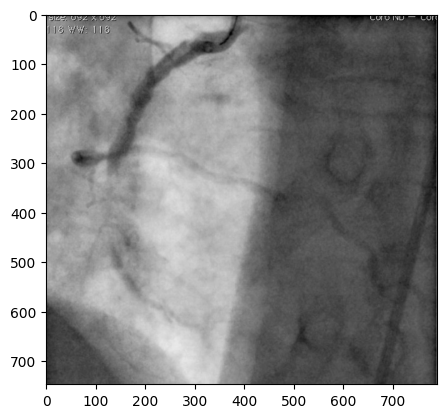

In [3]:
import os
import json

# Open the file for reading img_dir
# with open('../Experiments/filepath.json', 'r') as f:
#     # Use json.load to read data from file
#     data = json.load(f)
#     img_root_dir = data['roco-dataset']
# img_dir = os.path.join(img_root_dir, 'data/test/radiology/images')
img_dir = '../Experiments/test/'

query = 'lung'
# classes = ['brain', 'abdomen', 'breast']
# classes = ['mammography', 'CT', 'X-ray', 'ultrasound']
classes = ['man', 'woman']
# classes = ['malignancy', 'cancer', 'air']

img_path = os.listdir(img_dir)[0]
# img_path = "ROCO_00001.jpg"
caption = "Axial MRI (coronal view)."
# inputs = processor(text=[query], images=None, return_tensors="jax", padding=True)
# query_vec = model.get_text_features(**inputs)
print(img_path)
# Let's load a sample image
import os
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
plt.imshow(img, aspect='equal', cmap='gray')

In [4]:
class Transform(torch.nn.Module):
    def __init__(self, image_size=224):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size, image_size], interpolation=InterpolationMode.BICUBIC),
            ConvertImageDtype(torch.float),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            x = self.transforms(x)
        return x

In [5]:
sentences = [f'{c} with' for c in classes]
print(sentences)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
img_transforms = Transform()
pixel_values = img_transforms(torchvision.transforms.functional.pil_to_tensor(img)).numpy()
pixel_values = pixel_values.transpose((1, 2, 0))
pixel_values = pixel_values[np.newaxis, ...]
input_toks = tokenizer(sentences, max_length=128, padding="max_length", return_tensors="np",
                    truncation=True)
inputs = {'pixel_values': pixel_values, 'input_ids': input_toks['input_ids']}
outputs = model(**inputs)

['man with', 'woman with']


/home/yzhou/miniconda3/envs/medclip/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [14]:
print(outputs)

FlaxCLIPOutput(logits_per_image=Array([[0.10827827, 0.10434259]], dtype=float32), logits_per_text=Array([[0.10827827],
       [0.10434259]], dtype=float32), text_embeds=Array([[-0.03199735,  0.0003442 , -0.03434524, ..., -0.03519998,
        -0.00552053, -0.01843775],
       [-0.03155495,  0.00097442, -0.03608901, ..., -0.03478641,
        -0.00376551, -0.01869276]], dtype=float32), image_embeds=Array([[ 1.13547184e-02,  6.15457585e-03, -6.93813292e-03,
         9.72963520e-04, -1.19707882e-02, -1.01449989e-01,
         9.17342752e-02, -1.34376036e-02,  2.32708119e-02,
        -4.48047221e-02, -7.59665295e-02,  5.81358075e-02,
         6.17469698e-02,  3.85787338e-02,  1.20313680e-02,
         1.39914667e-02, -5.98693080e-02, -1.62929222e-02,
         7.14688003e-02,  7.81071857e-02, -3.84294279e-02,
        -1.71849248e-03,  1.24781411e-02,  7.11988891e-03,
        -3.21466289e-02,  1.22196544e-02,  4.25827177e-03,
        -1.96336899e-02, -4.01714146e-02,  9.00601894e-02,
        -3.

In [8]:
# sentences = [f'showing {c} in' for c in classes]
organs = ['breast', 'lung']
class_text = [f'{c} scan' for c in classes]
# sentences = [f'{organ} {t}' for organ in organs for t in class_text]

# max_seq_length = 128
# pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
# inputs = tokenizer(sentences, max_length=max_seq_length, padding="max_length", return_tensors="np",
#                     truncation=True)
# batch = {
#         "pixel_values": pixel_values,
#         "input_ids": inputs["input_ids"],
#         "attention_mask": inputs["attention_mask"],
#     }
inputs = processor(text=sentences, images=img, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)

outputs = model(**inputs)
print(outputs.logits_per_image)
print(outputs.logits_per_image.shape)
probs = jax.nn.softmax(outputs.logits_per_image, axis=-1)

for c_name, prob in zip(sentences, probs[0]):
    print(f'{c_name}: {prob:.2f}')
    

[[nan nan]]
(1, 2)
man with: nan
woman with: nan


In [15]:
# img_dir = os.path.join(img_root_dir, 'data/test/radiology/images')
img_dir = '../Experiments/test/'
query = 'lung'
img_list = os.listdir(img_dir)[:10]
imgs = [Image.open(os.path.join(img_dir, img_path)).convert('RGB') for img_path in img_list]
inputs = processor(text=[query], images=imgs, return_tensors="jax", padding=True)
inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
outputs = model(**inputs)
# print(outputs)
probs = jax.nn.softmax(outputs.logits_per_text, axis=-1)
# print(prob)

for img_name, prob in zip(img_list, probs[0]):
    print(f'{img_name}: {prob:.2f}')

ROCO_00031.jpg: nan
ROCO_00006.jpg: nan
ROCO_00138.jpg: nan
ROCO_00061.jpg: nan
ROCO_00016.jpg: nan
ROCO_00153.jpg: nan
ROCO_00001.jpg: nan
ROCO_00036.jpg: nan
ROCO_00025.jpg: nan
ROCO_00084.jpg: nan


In [13]:
# Encode a bunch of images using the model
embeddings = []
query = 'abdomen'
image_vec_file = 'test.txt'
img_dir = '../Experiments/test/'
fvec = open(image_vec_file, "w")
img_list = os.listdir(img_dir)[:9]

for idx, img_path in enumerate(img_list):
    if idx % 20 == 0:
        print(f"{idx} images processed")
    img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
    inputs = processor(images=img, return_tensors="jax", padding=True)
    inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
    img_vec = model.get_image_features(**inputs)
    img_vec = np.array(img_vec).reshape(-1)
    img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
    embeddings.append(np.array(img_vec).reshape(-1))
    fvec.write(f"{img_path}\t{img_vec_s}\n")

fvec.close()


0 images processed


In [14]:
# Encode a bunch of images using the model
embeddings = []
query = 'abdomen'
image_vec_file = 'test.txt'

fvec = open(image_vec_file, "w")
img_list = os.listdir(img_dir)[:20]

for idx, img_path in enumerate(img_list):
    if idx % 20 == 0:
        print(f"{idx} images processed")
    img = Image.open(os.path.join(img_dir, img_path)).convert('RGB')
    inputs = processor(images=img, return_tensors="jax", padding=True)
    inputs['pixel_values'] = inputs['pixel_values'].transpose(0, 2, 3, 1)
    img_vec = model.get_image_features(**inputs)
    img_vec = np.array(img_vec).reshape(-1)
    img_vec_s = ",".join(["{:.7e}".format(x) for x in img_vec])
    embeddings.append(np.array(img_vec).reshape(-1))
    fvec.write(f"{img_path}\t{img_vec_s}\n")

fvec.close()

0 images processed


In [15]:
import nmslib
def load_index(embedding_file):
    filenames, image_vecs = [], []
    with open(embedding_file, "r") as fvec:
        for line in fvec:
            cols = line.strip().split('\t')
            filename = cols[0]
            image_vec = np.array([float(x) for x in cols[1].split(',')])
            filenames.append(filename)
            image_vecs.append(image_vec)
    V = np.array(image_vecs)
    index = nmslib.init(method='hnsw', space='cosinesimil')
    index.addDataPointBatch(V)
    index.createIndex({'post': 2}, print_progress=True)
    return filenames, index

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱  1 import nmslib                                                                               │
│    2 def load_index(embedding_file):                                                             │
│    3 │   filenames, image_vecs = [], []                                                          │
│    4 │   with open(embedding_file, "r") as fvec:                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'nmslib'

In [ ]:
max_seq_length = 128
pixel_values = torch.stack([example[0] for example in examples]).permute(0, 2, 3, 1).numpy()
# pixel_values = torch.stack([example[0] for example in examples]).numpy()
captions = [example[1] for example in examples]
inputs = tokenizer(captions, max_length=max_seq_length, padding="max_length", return_tensors="np",
                    truncation=True)
batch = {
        "pixel_values": pixel_values,
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
    }
logits = model(**batch, train=False)[0]